In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell

nthreads = 10


In [2]:
include("../aux_functions.jl")
include("../inidat_aux_functions.jl")

SystemError: SystemError: opening file "/home/reula/Julia/PIC-1D/aux_functions.jl": No such file or directory

In [ ]:
undamped_l = false
undamped_s = false
damped = false
vlasov_exp_200 = false
vlasov_exp_40 = false
#undamped_s = true
damped = true
#vlasov_exp_40 = true
#vlasov_exp_200 = true

In [ ]:
run_name = "norel_norm_"
data_name = "par_dis_landau_norm_norel_"
if undamped_l
    const L = 39.738 
    const J = 3522
    nm = 2 # this is defined again in inidat lambda = L/nm = 19.869
    #nm = 20
    data_name = data_name * "undamped_l_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif undamped_s
    const L = 4
    const J = 80
    nm = 2 # this is defined again in inidat lambda = L/nm = 2 which gives a k approx 0.1
    #nm = 20
    data_name = data_name * "undamped_s_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif damped
    const L = 7.455
    const J = 930
    nm = 15 # this is defined again in inidat lambda = L/nm = 0.497
    data_name = data_name * "damped_$(nm)_"
    run_name = run_name * "damped_rel_"
elseif vlasov_exp_200
    const L = 200
    const J = 2000
    #const nm = 10 # para comparar con 40_2 
    const nm = 2 # this is defined again in inidat lambda = L/nm = 100
    data_name = data_name * "vla_200_$(nm)_"
    run_name = run_name * "vla_200rel_"
elseif vlasov_exp_40
    const L = 40
    const J = 400
    const nm = 2 # this is defined again in inidat lambda = L/nm = 20
    data_name = data_name * "vla_40_$(nm)_"
    run_name = run_name * "vla_40_rel_"
end

order = 4

exp_alpha = 2
α = 10.0^(-exp_alpha)

N_exp = 6 #6
N = 8*10^(N_exp)
exp_Theta = 3
θ = 10.0^(-exp_Theta)

@show data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)"

exp_t = 1 #2
t = 0.0
t_i = 0.0
t_f = 4*10.0^(exp_t)
M = 16001# 4001 # 81 # 2001 # time steps 
M_g = 8001 #400 + 1 #number of outputs, starting from the initial data

κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
#p = (L, N, J, κ, dx, order)
dt = (t_f-t_i) / (M-1)
@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, L, J, dx, order)
@show pars_f = (θ, nm, κ)
par_init = (α, 2π*nm/L)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N8$(N_exp)_n$(nm)_J$(J)_M$(M)_o$(order)_Th$(exp_Theta)_alp$(exp_alpha)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

In [ ]:
par_dis, data_name_from_inidat, pars, par_f_x, par_f_p = retrieve_initial_data("../Initial_Distributions/" * data_name * ".jld2")

@show data_name_from_inidat, pars, par_f_x, par_f_p

In [ ]:
average_outputs = true # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.

In [ ]:
E_i = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E

In [ ]:
get_density!(par_dis, n, par_grid,0.0)
get_ϕ!(ϕ, n .- 1., κ)
get_E_from_ϕ!(ϕ,E_i,dx)
u = [par_dis;E_i];
length(u)

In [ ]:
get_current_rel!(u, S, par_grid)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- 1.0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E_i))")

println("S_total = $(sum(S))")

In [ ]:
if !remote_server 
    plt = plot(layout=(2,2))
    plot!(subplot=1,x,n, title = "density", legend = :false)
    plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
    plot!(subplot=3,x,E_i, title = "Electric Field", legend = :false)
    
    plot!(subplot=4,x,S, title = "Current", legend = :false)
end

In [ ]:
n_Fourier = rfft(n.-1)
freqs_space = fftshift(fftfreq(J,1/dx))
#Plots.scatter(freqs_space,abs.(fftshift(n_Fourier)))
Plots.scatter(abs.(n_Fourier)[1:200])

In [ ]:
E_Fourier = rfft(u[2N+1:end])
Plots.scatter(abs.((E_Fourier)),xlim=(0,200))

In [ ]:

n_mp = zeros(J)
#=
Tn = zeros(nthreads())
get_density_threads!(par_dis, n_mp, (par_grid, Tn), 0.5) 
=#
get_density!(par_dis, n_mp, par_grid, 0.5)

In [ ]:
E_d = zeros(J)
get_E_direct!(E_d,-n_mp .+ 1.0, par_grid)

In [ ]:
sum(E_d)

In [ ]:
plot(E_d)
plot!(u[2N+1:end])

In [ ]:
include("../aux_functions.jl")

In [ ]:
m=16
rfft(E_d)[m]

In [ ]:
rfft(u[2N+1:end])[m]

## Testing test functions

In [9]:
using Plots, LinearAlgebra

In [10]:
include("../aux_functions/aux_functions.jl")
Box_x = [0.0,1.0,0.0,1.0]
J = (50,50)
dx = differentials(Box_x,J)
x_p = [(i-1)*dx[1] + Box_x[1] for i in 1:J[1]]
y_p = [(i-1)*dx[2] + Box_x[3] for i in 1:J[2]];

In [15]:
ϕ_test([0.3,0.4],[0.3,0.4],Box_x,0.1,6)

1.0

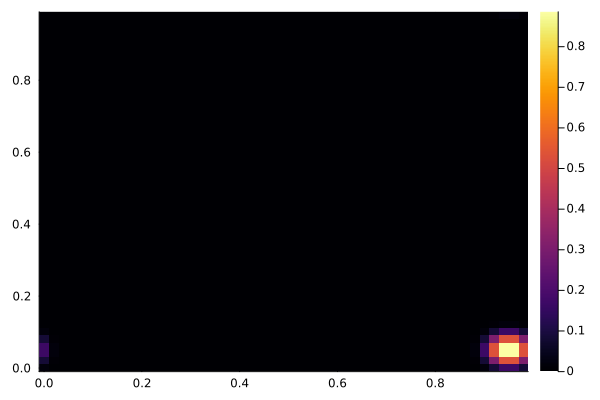

In [13]:
M = zeros(length(x_p),length(y_p))
for i in eachindex(x_p)
    for j in eachindex(y_p)
        M[i,j] = ϕ_test([x_p[i],y_p[j]],[0.05, 0.95],Box_x,0.1,6)
    end
end

#surface(y_p,x_p,M)
heatmap(y_p,x_p,M)

In [24]:
norm(M)
sum(M)

11.219971408896015

In [17]:
∇ϕ_test([0.2,0.9],[0.3,0.9],Box_x,0.2,6)

2-element Vector{Float64}:
  7.119140625000005
 -0.0

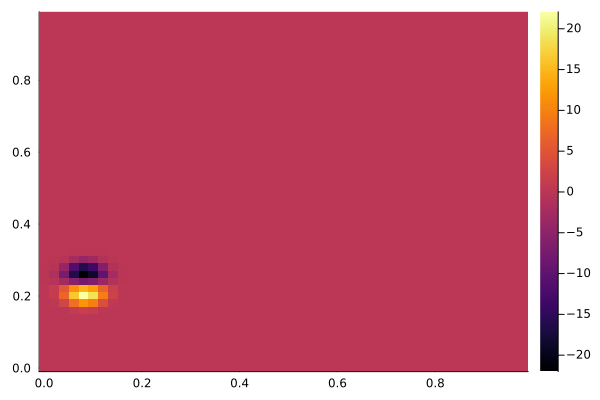

In [20]:
D=2
DM = zeros(length(x_p),length(y_p),D)
for i in eachindex(x_p)
    for j in eachindex(y_p)
        for d in 1:D
            DM[i,j,d] = ∇ϕ_test([x_p[i],y_p[j]],[0.23344977163645686, 0.08282256411562228],Box_x,0.1,6)[d]
        end
    end
end

#surface(y_p,x_p,DM[:,:,2])
heatmap(y_p,x_p,DM[:,:,1])

In [23]:

sum(DM)/norm(DM)

8.597121495697237e-6